# Call Annotations

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import liana as li

In [2]:
from utils import run_rf_auc, run_stlearn, convert_scanpy, run_local, efficiency_wrapper

In [3]:
data_dir = os.path.join('..', '..', 'data', 'wu_et_al')
dataset_names = ['1160920F', 'CID44971', 'CID4535', '1142243F'] # 'CID4465', 'CID4290 are both basically cancer only

In [4]:
function_names = li.mt.bivar.show_functions()['name'].values

In [5]:
# function_names = function_names[0:1]
# insert stLearn
# dataset_names = [dataset_names[0]]
function_names = np.insert(function_names, 0, 'stLearn')

In [6]:
import time

Run on all data

In [7]:
performances = {}
# Initialize an empty DataFrame
efficiency = pd.DataFrame(columns=['dataset_name', 'function_name', 'time'])

for dataset_name in dataset_names:
    print(f"Running {dataset_name}")
    adata = sc.read_h5ad(os.path.join(data_dir, f"{dataset_name}.h5ad"))
    
    adata.uns['function_names'] = function_names
    
    # to binary
    adata.obs['Classification'][adata.obs['Classification'].isna()] = 'Artefact'
    adata.obs['spot_label'] = adata.obs['Classification'].str.contains('cancer').astype(int)
    
    # Preprocess
    sc.pp.filter_cells(adata, min_genes=400)
    sc.pp.filter_genes(adata, min_cells=20)

    adata.layers["counts"] = adata.X.copy()
    
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    
    # NOTE: stLearn specific
    adata = convert_scanpy(adata)
    
    # Run all functions
    for function_name in function_names:
        print(f"Running {function_name}")
        
        start_time = time.time()
        
        if function_name == 'stLearn':
            run_stlearn(adata)
        else:
            if function_name not in ['product', 'norm_product']:
                standardize = False
            else:
                standardize = True
            
            run_local(adata, function_name, standardize=standardize)
            
        end_time = time.time()
        efficiency = efficiency.append({'dataset_name': dataset_name,
                                        'function_name': function_name,
                                        'time': end_time - start_time},
                                       ignore_index=True)
        
    # eval LR basis
    run_rf_auc(adata, dataset_name)
    os.makedirs(os.path.join(data_dir, 'results'), exist_ok=True)
    performance = adata.uns['performance']
    performances[dataset_name] = performance


Running 1160920F
Running stLearn
Calculating neighbours...
0 spots with no neighbours, 6 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 2510 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|██████████ [ time left: 00:00 ]  



Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].
Running pearson


/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:41<00:00,  2.42it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running spearman


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [02:49<00:00,  1.69s/it]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running cosine


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:08<00:00, 11.81it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running jaccard


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:10<00:00,  9.60it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running product


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:08<00:00, 11.67it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running norm_product


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:10<00:00,  9.40it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running morans


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:03<00:00, 25.82it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running masked_spearman


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [24:53<00:00, 14.94s/it]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Evaluating 1160920F; Fold: 0
Evaluating 1160920F; Fold: 1
Evaluating 1160920F; Fold: 2
Evaluating 1160920F; Fold: 3
Evaluating 1160920F; Fold: 4
Evaluating 1160920F; Fold: 5
Evaluating 1160920F; Fold: 6
Evaluating 1160920F; Fold: 7
Evaluating 1160920F; Fold: 8
Evaluating 1160920F; Fold: 9
Running CID44971
Running stLearn
Calculating neighbours...
1 spots with no neighbours, 6 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 2273 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|██████████ [ time left: 00:00 ]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!



Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].
Running pearson


100%|██████████| 100/100 [00:05<00:00, 18.08it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!


Running spearman


100%|██████████| 100/100 [00:31<00:00,  3.14it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.


Running cosine


Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:02<00:00, 46.57it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!


Running jaccard


100%|██████████| 100/100 [00:02<00:00, 41.10it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.


Running product


Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:01<00:00, 58.50it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.


Running norm_product


Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:02<00:00, 41.48it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.


Running morans


Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:00<00:00, 118.73it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.


Running masked_spearman


Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [08:49<00:00,  5.29s/it]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Evaluating CID44971; Fold: 0
Evaluating CID44971; Fold: 1
Evaluating CID44971; Fold: 2
Evaluating CID44971; Fold: 3
Evaluating CID44971; Fold: 4
Evaluating CID44971; Fold: 5
Evaluating CID44971; Fold: 6
Evaluating CID44971; Fold: 7
Evaluating CID44971; Fold: 8
Evaluating CID44971; Fold: 9
Running CID4535
Running stLearn
Calculating neighbours...
2 spots with no neighbours, 6 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 1970 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|██████████ [ time left: 00:00 ]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!



Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].
Running pearson


100%|██████████| 100/100 [00:04<00:00, 23.95it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!


Running spearman


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!


Running cosine


100%|██████████| 100/100 [00:01<00:00, 65.97it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!


Running jaccard


100%|██████████| 100/100 [00:01<00:00, 58.16it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!


Running product


100%|██████████| 100/100 [00:01<00:00, 77.33it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!


Running norm_product


100%|██████████| 100/100 [00:01<00:00, 51.83it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.


Running morans


Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:00<00:00, 146.07it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Using resource `consensus`.


Running masked_spearman


Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [06:28<00:00,  3.88s/it]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Evaluating CID4535; Fold: 0
Evaluating CID4535; Fold: 1
Evaluating CID4535; Fold: 2
Evaluating CID4535; Fold: 3
Evaluating CID4535; Fold: 4
Evaluating CID4535; Fold: 5
Evaluating CID4535; Fold: 6
Evaluating CID4535; Fold: 7
Evaluating CID4535; Fold: 8
Evaluating CID4535; Fold: 9
Running 1142243F
Running stLearn
Calculating neighbours...
0 spots with no neighbours, 6 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 2354 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|██████████ [ time left: 00:00 ]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].
Running pearson


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:23<00:00,  4.17it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running spearman


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [02:15<00:00,  1.35s/it]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running cosine


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:08<00:00, 11.21it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running jaccard


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:08<00:00, 12.41it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running product


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:07<00:00, 13.37it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running norm_product


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:09<00:00, 10.55it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running morans


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [00:03<00:00, 28.51it/s]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Running masked_spearman


Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
100%|██████████| 100/100 [23:17<00:00, 13.97s/it]
/tmp/ipykernel_1483006/559592751.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Evaluating 1142243F; Fold: 0
Evaluating 1142243F; Fold: 1
Evaluating 1142243F; Fold: 2
Evaluating 1142243F; Fold: 3
Evaluating 1142243F; Fold: 4
Evaluating 1142243F; Fold: 5
Evaluating 1142243F; Fold: 6
Evaluating 1142243F; Fold: 7
Evaluating 1142243F; Fold: 8
Evaluating 1142243F; Fold: 9


In [8]:
efficiency.to_csv(os.path.join('efficiency.csv'), index=False)

In [11]:
# save results
performance = pd.concat(performances, names=['dataset_name', None])
performance.to_csv("annotation_results.csv")

In [23]:
performance = pd.read_csv("annotation_results.csv")
efficiency = pd.read_csv("efficiency.csv")

In [24]:
efficiency.sort_values("time").head()

,dataset_name,function_name,time
23,CID4535,product,3.788131
21,CID4535,cosine,4.023909
22,CID4535,jaccard,4.278966
14,CID44971,product,4.342767
24,CID4535,norm_product,4.516056


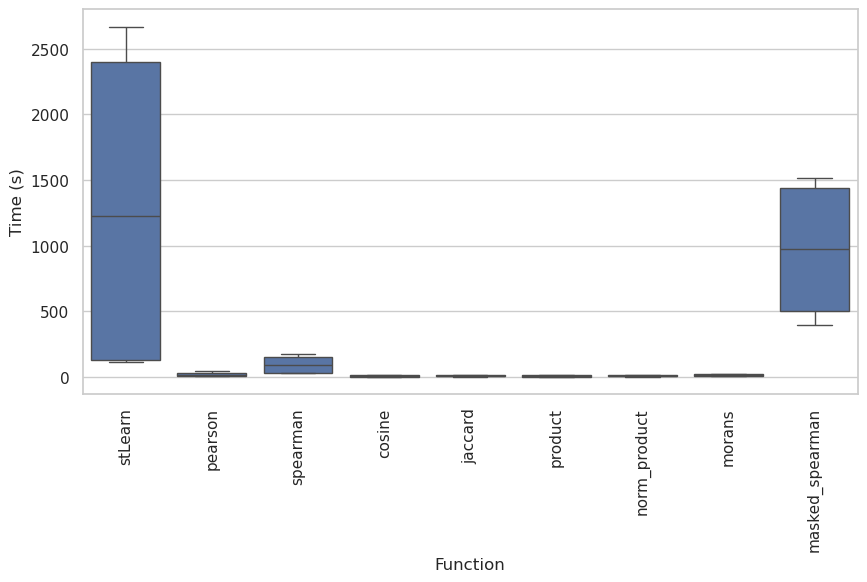

In [25]:
### boxplot by time
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="function_name", y="time", data=efficiency)
plt.xticks(rotation=90)
# axis labels
plt.xlabel('Function')
plt.ylabel('Time (s)')
plt.show()